In [1]:
# 使用Jupyter Notebook的magic命令加载autoreload扩展
%load_ext autoreload
# 设置autoreload模式为2，这意味着在执行代码前，所有已加载的模块都会被自动重新加载
%autoreload 2
# 启用matplotlib内联显示
%matplotlib inline
#______________________________________________________________________________
# 导入os模块，用于与操作系统进行交互，例如文件路径操作
import os
# 导入sys模块，用于访问Python解释器使用或维护的变量以及与之交互的函数
import sys
# 导入time模块，提供各种时间相关的功能
import time
# 导入NumPy库，它是Python中用于科学计算的核心库，常用于处理数组和矩阵
import numpy as np
# 导入matplotlib.pyplot，这是一个用于创建静态、动画和交互式可视化的绘图库
import matplotlib.pyplot as plt
# 导入scikit-learn库，一个用于机器学习的流行库
import sklearn
# 导入_pickle模块，用于Python对象序列化
import _pickle as pkl
# 从shap_utils.py文件中导入所有工具函数
from shap_utils import *
# 从DistShap.py文件中导入DistShap类，这是计算数据价值的核心类
from DistShap import DistShap
# 从Shapley.py文件中导入ShapNN类，这是一个基于TensorFlow的神经网络模型
from Shapley import ShapNN
# 使用Jupyter Notebook的magic命令，使matplotlib绘制的图形直接在Notebook中显示
%matplotlib inline

加载（如果需要则下载）CoverType数据集。这是一个经典的多分类数据集，用于根据地形学数据预测森林覆盖类型。

In [2]:
# 从scikit-learn的数据集模块中导入fetch_covtype函数
from sklearn.datasets import fetch_covtype
# 调用fetch_covtype函数加载数据集
# return_X_y=True 表示将数据集分为特征(data)和目标标签(target)两部分返回
data, target = fetch_covtype(return_X_y=True)

我们将为200个数据点计算D-Shapley和TMC-Shapley值。对于D-Shapley，我们将截断参数 $m$ 设置为200。

In [3]:
# 设置用于评估数据价值的模型类型为逻辑回归
model_family = 'logistic'
# 设置训练集的大小，即我们将为这200个数据点计算价值
train_size = 200
# 设置D-Shapley的截断参数m，表示从分布中采样的子集大小上限
m = 200
# 设置加权采样参数alpha为None，表示不使用加权采样
alpha = None # Weighted sampling parameter
# 设置用于评估的测试数据点总数（包括测试集和留出集）
num_test = 5000
# 设置测试集的大小
test_size = 1000
# 设置留出集的大小，用于在数据点移除/添加实验中评估模型性能
heldout_size = 1000
# 设置存储临时结果和模型的目录
directory = './temp/covertype'
# 设置随机种子以保证实验结果的可复现性
np.random.seed(0)
# 生成一个随机的索引排列，用于打乱数据
idxs = np.random.permutation(len(data))
# 根据随机索引打乱数据和标签。标签减1是为了将类别从1-7转换为0-6
data, target = data[idxs], target[idxs] - 1
# 从打乱后的数据中划分出训练集
X_train, y_train = data[:train_size], target[:train_size]
# 划分出用于D-Shapley采样的背景分布数据集
X_dist, y_dist = data[train_size:-(test_size+heldout_size)], target[train_size:-(test_size+heldout_size)]
# 划分出测试集和留出集
X_test, y_test = data[-(test_size+heldout_size):], target[-(test_size+heldout_size):]
# 定义一个数据标准化函数，使用背景分布数据集的均值和标准差
normalizer_fn = lambda X: (X - np.mean(X_dist, 0)) / np.clip(np.std(X_dist, 0), 1e-12, None)
# 对训练集、背景分布数据集和测试集进行标准化处理
X_train, X_dist, X_test = normalizer_fn(X_train), normalizer_fn(X_dist), normalizer_fn(X_test)

In [ ]:

import time
import os

# 检查目录是否存在
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"创建目录: {directory}")

QUICK_TEST = False 

if QUICK_TEST:
    print("启用快速测试模式")
    # 使用更小的数据集进行快速测试
    quick_size = 20
    X_train_test = X_train[:quick_size]
    y_train_test = y_train[:quick_size]
    X_test_test = X_test[:100]
    y_test_test = y_test[:100]
    directory_test = './temp/covertype_quicktest'
    
    print(f" 快速测试训练集: {len(X_train_test)} 个数据点")
    print(f"✓快速测试集: {len(X_test_test)} 个数据点")
    
    if not os.path.exists(directory_test):
        os.makedirs(directory_test)
else:
    print("完整实验模式")
    X_train_test = X_train
    y_train_test = y_train  
    X_test_test = X_test
    y_test_test = y_test
    directory_test = directory

# 检查数据和模型状态
print("实验前检查:")
print(f"✓ 训练集大小: {len(X_train_test)} 个数据点")
print(f"✓ 特征维度: {X_train_test.shape[1]}")
print(f"✓ 类别数: {len(set(y_train_test))}")
print(f"✓ 背景分布数据集大小: {len(X_dist)}")
print(f"✓ 测试集大小: {len(X_test_test)}")
print(f"✓ 存储目录: {directory_test}")


🚀 完整实验模式
实验前检查:
✓ 训练集大小: 200 个数据点
✓ 特征维度: 54
✓ 类别数: 7
✓ 背景分布数据集大小: 578812
✓ 测试集大小: 2000
✓ 存储目录: ./temp/covertype

开始完整实验...
预计运行时间: 30-90分钟（取决于硬件配置）
注意: 可以随时用Ctrl+C中断，已保存的结果不会丢失


定义并初始化Dist-Shapley模块。

In [ ]:
# 计算完成，显示运行时间和结果摘要
end_time = time.time()
elapsed_time = end_time - start_time

print("=" * 60)
print(f"计算完成！总用时: {elapsed_time/60:.1f} 分钟")
print("\n结果摘要:")
try:
    print(f"- TMC-Shapley迭代次数: {len(dshap.results['mem_tmc'])}")
    print(f"- D-Shapley迭代次数: {len(dshap.results['mem_dist'])}")
    print(f"- D-SVARM迭代次数: {len(dshap.results['mem_dsvarm'])}")
except:
    print("- 结果正在加载中...")

print(f"- 结果已保存到: {directory}")
print("✓ 可以继续运行后续的分析和可视化代码")


🎉 计算完成！总用时: 0.0 分钟

结果摘要:
- 结果正在加载中...
- 结果已保存到: ./temp/covertype
✓ 可以继续运行后续的分析和可视化代码


In [6]:
# 设置overwrite为False，表示如果目录已存在，则不删除旧结果
overwrite = False #If True, will remove old results.
# 实例化DistShap类，传入准备好的数据集和各项参数
dshap = DistShap(X=X_train, y=y_train,           # 需要评估价值的训练数据
                 X_test=X_test, y_test=y_test,   # 测试和留出数据
                 num_test=test_size,             # 测试集大小
                 X_tot=X_dist, y_tot=y_dist,     # D-Shapley的背景分布数据
                 sources=None,                   # 数据源信息，None表示每个点都是一个独立源
                 sample_weight=None,             # 样本权重，None表示无权重
                 model_family=model_family,      # 学习模型类型
                 metric='accuracy',              # 评估指标
                 overwrite=overwrite,            # 是否覆盖已有结果
                 directory=directory)            # 结果存储目录

000005


运行两种算法的迭代计算。注意：由于两种算法的迭代是相互独立的，因此它们可以并行运行。这个计算过程可能需要一段时间才能收敛。

In [7]:
# 调用run方法开始计算数据价值
dshap.run(tmc_run=True,      # 启动TMC-Shapley计算
          dist_run=True,     # 启动D-Shapley计算
          dsvarm_run=True,   # 启动D-SVARM计算
          truncation=m,      # 设置D-Shapley的截断参数
          alpha=alpha,       # 设置加权采样参数
          save_every=10,     # 每10次迭代保存一次结果
          err=0.05)          # 设置收敛的误差阈值

1 out of 10 Dist_Shapley iterations.
2 out of 10 Dist_Shapley iterations.
3 out of 10 Dist_Shapley iterations.
4 out of 10 Dist_Shapley iterations.
5 out of 10 Dist_Shapley iterations.
6 out of 10 Dist_Shapley iterations.
7 out of 10 Dist_Shapley iterations.
8 out of 10 Dist_Shapley iterations.
9 out of 10 Dist_Shapley iterations.
10 out of 10 Dist_Shapley iterations.
1 out of 10 TMC_Shapley iterations.
Truncated at 130
2 out of 10 TMC_Shapley iterations.
3 out of 10 TMC_Shapley iterations.
Truncated at 116
4 out of 10 TMC_Shapley iterations.
Truncated at 169
5 out of 10 TMC_Shapley iterations.
6 out of 10 TMC_Shapley iterations.
Truncated at 198
7 out of 10 TMC_Shapley iterations.
Truncated at 196
8 out of 10 TMC_Shapley iterations.
Truncated at 86
9 out of 10 TMC_Shapley iterations.
Truncated at 175
10 out of 10 TMC_Shapley iterations.
Truncated at 160
1 out of 10 D-SVARM iterations.
2 out of 10 D-SVARM iterations.
3 out of 10 D-SVARM iterations.
4 out of 10 D-SVARM iterations.
5 out

加载当前和之前保存的所有计算结果。

In [8]:
# 从目录中加载所有保存的Shapley值计算结果
dshap.load_results(verbose=False)
# 计算每个数据点TMC-Shapley值的平均值
vals_tmc = np.mean(dshap.results['mem_tmc'], 0)
# 计算每个数据点D-SVARM-Shapley值的平均值
vals_dsvarm = np.mean(dshap.results['mem_dsvarm'], 0)
# 检查是否使用了加权采样
if alpha is None:
    # 如果没有使用加权采样，直接计算D-Shapley值的平均值
    vals_dist = np.mean(dshap.results['mem_dist'], 0)
else:
    # 如果使用了加权采样，需要根据采样概率对边际贡献进行加权平均，以得到无偏估计
    # 计算每个采样大小的出现次数
    sizes = np.array([len(i) for i in dshap.results['idxs_dist']])
    # 计算每个采样大小的采样概率
    ps = np.expand_dims(1/(sizes ** alpha), -1) / np.sum(1 / (np.arange(1, m + 1) ** alpha))
    # 对边际贡献进行加权平均，得到最终的D-Shapley值
    vals_dist = np.mean(dshap.results['mem_dist'] / (ps * m), 0)

接下来，我们来研究论文第4节中提到的案例。
假设一个买家最初拥有100个数据点，然后又从卖家那里获得了100个数据点（总共200个）。我们已经为这200个点计算了TMC-Shapley值（作为买家视角的公允价值）和D-Shapley值（作为卖家视角的公允价值）。
我们将通过数据点移除/添加实验来绘制性能曲线，以比较这两种价值评估方法的有效性。

In [9]:
# 将后100个数据点作为卖方提供的新数据
X_new, y_new = dshap.X[100:], dshap.y[100:]
# 获取这100个新数据对应的TMC-Shapley、D-Shapley和D-SVARM值
vals_tmc_new, vals_dist_new, vals_dsvarm_new = vals_tmc[100:], vals_dist[100:], vals_dsvarm[100:]
# 将前100个数据点作为买方原有的初始数据
X_init, y_init = dshap.X[:100], dshap.y[:100]
# 计算两种Shapley值之间的斯皮尔曼等级相关系数，以衡量它们的排序一致性
print('Rank correlation of data shapley vs distributional shapley values = {0:.3f}'.format(
    spearmanr(vals_tmc_new, vals_dist_new)[0]))
# 计算两种Shapley值总和的绝对百分比误差，以衡量它们在总量上的差异
print('Absoulte percentage error of overal data shapley vs distributional shapley value = {0:.1f}%'.format(
    100 * np.abs(np.sum(vals_tmc_new) - np.sum(vals_dist_new)) / np.sum(vals_tmc_new)))

Rank correlation of data shapley vs distributional shapley values = 0.618
Absoulte percentage error of overal data shapley vs distributional shapley value = 2.6%


In [10]:
# 定义在实验中评估性能的时间点（例如，每添加5%的数据点评估一次）
performance_points = np.arange(0, len(X_new)+1, len(X_new)//20)
# 定义一个lambda函数，用于执行数据点添加实验并返回性能曲线
# 该函数接受一个数据点顺序（order），并根据该顺序逐步将X_new中的点添加到X_init上，然后评估模型在留出集上的性能
perf_func = lambda order: portion_performance(
        dshap, order, performance_points,
        X_new, y_new, X_init, y_init, dshap.X_heldout, dshap.y_heldout)

In [11]:
# 重新定义性能评估点，这次实验只添加一半（50个）的新数据点，评估更频繁
performance_points = np.arange(0, len(X_new)//2, len(X_new)//40)
# 按照D-Shapley值从高到低的顺序添加数据点，计算性能曲线
d_perf_inc = perf_func(np.argsort(-vals_dist_new))
# 按照TMC-Shapley值从高到低的顺序添加数据点，计算性能曲线
tmc_perf_inc = perf_func(np.argsort(-vals_tmc_new))
# 按照D-SVARM-Shapley值从高到低的顺序添加数据点，计算性能曲线
dsvarm_perf_inc = perf_func(np.argsort(-vals_dsvarm_new))
# 随机打乱数据点顺序5次，计算平均性能曲线，作为基线
rnd_perf_inc = np.mean([perf_func(np.random.permutation(len(X_new))) for _ in range(5)], 0)

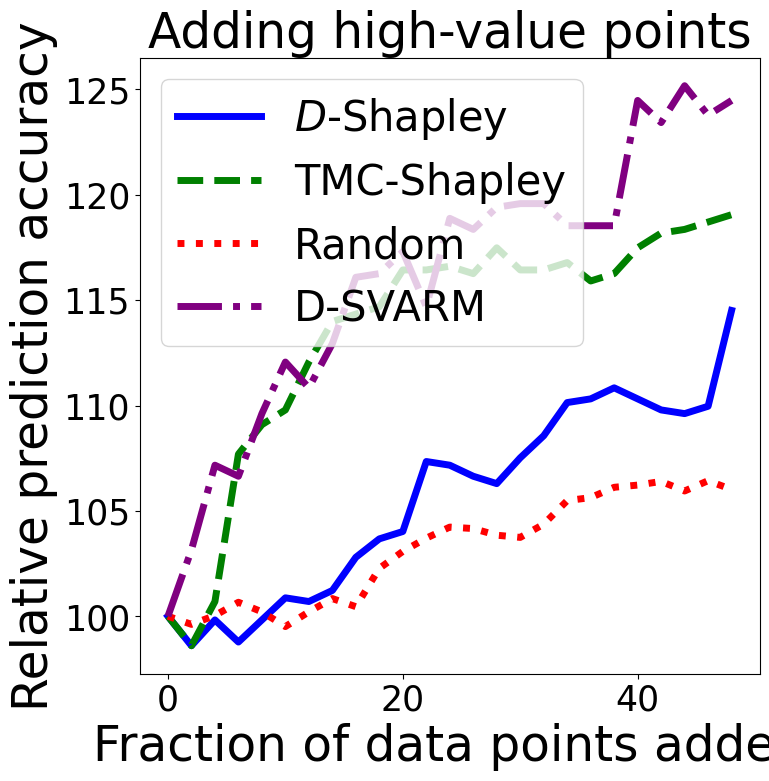

In [12]:
# 设置matplotlib绘图的全局字体大小
plt.rcParams['font.size'] = 25
# 创建一个新的图形，设置尺寸为8x8英寸
fig = plt.figure(figsize=(8, 8))
# 绘制D-Shapley的性能曲线（实线，蓝色）
# x轴是添加数据点的百分比，y轴是相对于初始模型性能的百分比
plt.plot(performance_points / len(X_new) * 100, d_perf_inc / d_perf_inc[0] * 100,
         linestyle='solid', c='b', lw=5)
# 绘制TMC-Shapley的性能曲线（虚线，绿色）
plt.plot(performance_points / len(X_new) * 100, tmc_perf_inc / tmc_perf_inc[0] * 100,
         linestyle='dashed', c='g', lw=5)
# 绘制随机顺序的性能曲线（点线，红色）
plt.plot(performance_points / len(X_new) * 100, rnd_perf_inc / rnd_perf_inc[0] * 100,
         linestyle='dotted', c='r', lw=5)
# 新增D-SVARM曲线
plt.plot(performance_points / len(X_new) * 100, dsvarm_perf_inc / dsvarm_perf_inc[0] * 100,
         linestyle='dashdot', c='purple', lw=5)
# 设置x轴标签
plt.xlabel('Fraction of data points added', fontsize=35)
# 设置y轴标签
plt.ylabel('Relative prediction accuracy', fontsize=35)
# 设置图例
plt.legend(['$D$-Shapley', 'TMC-Shapley', 'Random', 'D-SVARM'], fontsize=30)
# 设置图标题
plt.title('Adding high-value points', fontsize=35)
# 显示图像
plt.show()

我们可以做同样的事情，但是方向相反（即首先添加价值最低的数据点）。

In [13]:
# 重新定义性能评估点，与上一个实验相同
performance_points = np.arange(0, len(X_new)//2, len(X_new)//40)
# 按照D-Shapley值从低到高的顺序添加数据点，计算性能曲线
d_perf_dec = perf_func(np.argsort(vals_dist_new))
# 按照TMC-Shapley值从低到高的顺序添加数据点，计算性能曲线
tmc_perf_dec = perf_func(np.argsort(vals_tmc_new))
# 按照D-SVARM-Shapley值从低到高的顺序添加数据点，计算性能曲线
dsvarm_perf_dec = perf_func(np.argsort(vals_dsvarm_new))
# 随机打乱数据点顺序5次，计算平均性能曲线，作为基线
rnd_perf_dec = np.mean([perf_func(np.random.permutation(len(X_new))) for _ in range(5)], 0)

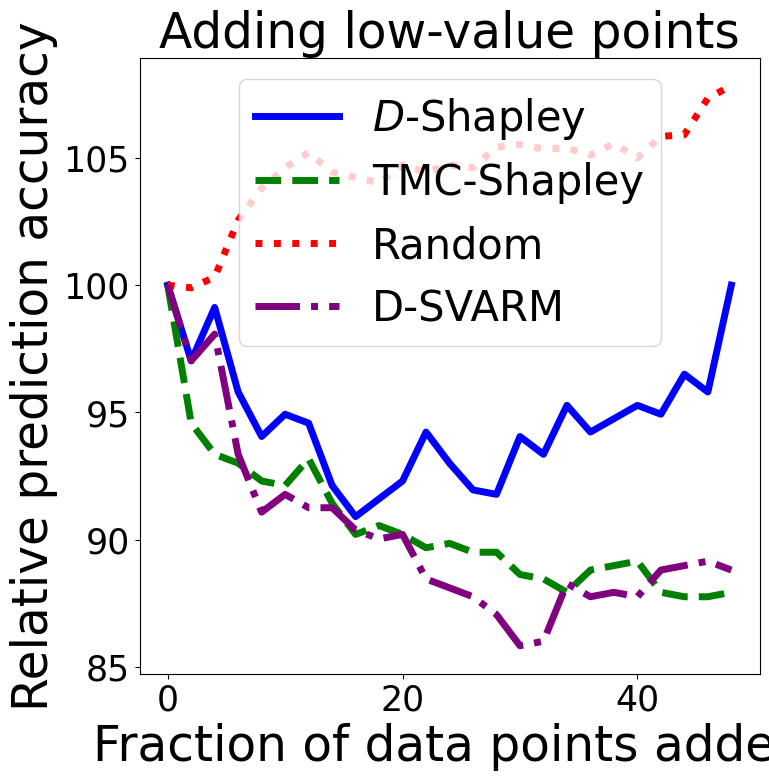

In [14]:
# 设置matplotlib绘图的全局字体大小
plt.rcParams['font.size'] = 25
# 创建一个新的图形，设置尺寸为8x8英寸
fig = plt.figure(figsize=(8, 8))
# 绘制D-Shapley的性能曲线（实线，蓝色）
plt.plot(performance_points / len(X_new) * 100, d_perf_dec / d_perf_dec[0] * 100,
         linestyle='solid', c='b', lw=5)
# 绘制TMC-Shapley的性能曲线（虚线，绿色）
plt.plot(performance_points / len(X_new) * 100, tmc_perf_dec / tmc_perf_dec[0] * 100,
         linestyle='dashed', c='g', lw=5)
# 绘制随机顺序的性能曲线（点线，红色）
plt.plot(performance_points / len(X_new) * 100, rnd_perf_dec / rnd_perf_dec[0] * 100,
         linestyle='dotted', c='r', lw=5)
# 新增D-SVARM曲线
plt.plot(performance_points / len(X_new) * 100, dsvarm_perf_dec / dsvarm_perf_dec[0] * 100,
         linestyle='dashdot', c='purple', lw=5)
# 设置x轴标签
plt.xlabel('Fraction of data points added', fontsize=35)
# 设置y轴标签
plt.ylabel('Relative prediction accuracy', fontsize=35)
# 设置图例
plt.legend(['$D$-Shapley', 'TMC-Shapley', 'Random', 'D-SVARM'], fontsize=30)
# 设置图标题
plt.title('Adding low-value points', fontsize=35)
# 显示图像
plt.show()